## About the Dataset

This is a simulated credit card transaction dataset containing legitimate and fraud transactions from the duration 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants.

## Source of Simulation

This was generated using Sparkov Data Generation | Github tool created by Brandon Harris. This simulation was run for the duration - 1 Jan 2019 to 31 Dec 2020. The files were combined and converted into a standard format.

The simulator has certain pre-defined list of merchants, customers and transaction categories. And then using a python library called "faker", and with the number of customers, merchants that you mention during simulation, an intermediate list is created.

After this, depending on the profile you choose for e.g. "adults 2550 female rural.json" (which means simulation properties of adult females in the age range of 25-50 who are from rural areas), the transactions are created. Say, for this profile, you could check "Sparkov | Github | adults_2550_female_rural.json", there are parameter value ranges defined in terms of min, max transactions per day, distribution of transactions across days of the week and normal distribution properties (mean, standard deviation) for amounts in various categories. Using these measures of distributions, the transactions are generated using faker.

What I did was generate transactions across all profiles and then merged them together to create a more realistic representation of simulated transactions.

## Acknowledgements

Brandon Harris for his amazing work in creating this easy-to-use simulation tool for creating fraud transaction datasets.

## Introduction
Credit card fraud has shown a significant increase in attempted fraud, with e-commerce credit card fraud in the U.S. rising by 140%. Globally, 46% of credit card fraud occurs in the U.S., and global losses are projected to reach $43 billion by 2026, surpassing the GDP of many countries. Within ten years, these losses are expected to reach $397.4 billion, equivalent to the annual revenue of some Fortune 500 companies.

The statistics paint a grim picture of the widespread nature of credit card fraud. A staggering 80% of all credit cards in circulation have been compromised, and 65% of all credit and debit cardholders have been victims of fraud. The leading type of identity theft, card-not-present fraud, accounts for 65% of losses. The average credit card fraud case reported to police is $400, with a median charge of $79. Shockingly, 20% of cardholders have experienced fraud two or more times, and 150 million Americans were victims last year. For every $1 lost to online fraud, merchants incur an [actual cost](https://merchantcostconsulting.com/lower-credit-card-processing-fees/credit-card-fraud-statistics/) of $3.75. This is not just a statistic but a call to action for all of us to be vigilant. A significant portion of the population (20% globally, 10% in the U.S. annually) has been affected by compromised records or identity theft. 

### Import the necessary libraries

In [21]:
# Path to user functions
import sys
sys.path.append("../Src/")
# display Python Version
from platform import python_version
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# user functions
import utilities as u

# Initialize variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

Numpy Version: 2.3.1
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.10.0
Python Version: 3.13.5


### Load the dataset & Combine the train and test datasets

In [22]:
# Load the CSV files
print("Loading fraudTrain.csv...")
fraud_train = pd.read_csv("../Data/fraudTrain.csv")
print(f"Training data shape: {fraud_train.shape}")

print("\nLoading fraudTest.csv...")
fraud_test = pd.read_csv("../Data/fraudTest.csv")
print(f"Test data shape: {fraud_test.shape}")

# Combine the datasets
print("\nCombining datasets...")
df = pd.concat([fraud_train, fraud_test], ignore_index=True)
print(f"Combined data shape: {df.shape}")

# reset index after concatenation
df.reset_index(drop=True, inplace=True)

Loading fraudTrain.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Training data shape: (1296675, 23)

Loading fraudTest.csv...
Test data shape: (555719, 23)

Combining datasets...
Combined data shape: (1852394, 23)
Test data shape: (555719, 23)

Combining datasets...
Combined data shape: (1852394, 23)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud          

In [24]:
# Checking for nulls
df.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [25]:
df.is_fraud.value_counts()

is_fraud
0    1842743
1       9651
Name: count, dtype: int64

In [26]:
df.is_fraud.value_counts(normalize=True)

is_fraud
0    0.99479
1    0.00521
Name: proportion, dtype: float64

### Observations :
- From above we can observe that there is 23 features and 1,852,394 rows
- This is highly imbalanced class data
    - We can try with the imbalabnce but we need to balance the dependent variable

In [27]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


### Data Wrangling

In [28]:
# # remove columns
# remove_cols = ['Unnamed: 0', 'street', 'trans_num', 'unix_time', ]
# # drop columns
# df.drop(columns=remove_cols, inplace=True, errors='ignore')

# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
# Convert dob to datetime
df['dob'] = pd.to_datetime(df['dob'])

# remove 'fraud_' prefix from the 'merchant' column
df['merchant'] = df['merchant'].str.replace('^fraud_', '', regex=True)

# display
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Feature Engineering

In [39]:
# Current date
today = pd.Timestamp.today()

# determine month, day of the week
df['trans_month'] = df.trans_date_trans_time.dt.month_name()
df['trans_day_of_week'] = df.trans_date_trans_time.dt.day_name()
df['trans_hour'] = df['trans_date_trans_time'].dt.hour.astype(str).str.zfill(2)

# Calculate age
df['age'] = df['dob'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

#
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_lat,merch_long,is_fraud,trans_month,trans_day_of_week,trans_hour,age,industry,cc_network,store_distance
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.011293,-82.048315,0,January,Tuesday,00,37,Airlines & Financial,Mastercard,48.838332
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,49.159047,-118.186462,0,January,Tuesday,00,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,43.150704,-112.154481,0,January,Tuesday,00,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,47.034331,-112.561071,0,January,Tuesday,00,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.674999,-78.632459,0,January,Tuesday,00,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592


In [40]:
# Create a mapping for industry identifier
mii_to_industry = {
    '1': 'Airlines',
    '2': 'Airlines & Financial',
    '3': 'Travel & Entertainment (e.g., American Express, Diners Club)',
    '4': 'Banking & Financial (e.g., Visa)',
    '5': 'Banking & Financial (e.g., Mastercard)',
    '6': 'Merchandising & Banking (e.g., Discover)',
    '7': 'Petroleum',
    '8': 'Healthcare & Telecommunications',
    '9': 'National Assignment / Other'
}

# apply lamda function to map first digit of cc_num to industry
df['industry'] = df['cc_num'].apply(lambda x: u.map_first_digit_to_value(x, mapping_dict=mii_to_industry))

# determe credit card network
df['cc_network'] = df['cc_num'].apply(lambda x: u.get_credit_card_network(str(x)))

# determine store distance
df['store_distance'] = df.apply(
    lambda x: u.haversine_distance_calc(x['lat'], x['long'], x['merch_lat'], x['merch_long']),
    axis=1
)

# Display the first few rows of the updated DataFrame
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_lat,merch_long,is_fraud,trans_month,trans_day_of_week,trans_hour,age,industry,cc_network,store_distance
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.011293,-82.048315,0,January,Tuesday,00,37,Airlines & Financial,Mastercard,48.838332
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,49.159047,-118.186462,0,January,Tuesday,00,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,43.150704,-112.154481,0,January,Tuesday,00,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,47.034331,-112.561071,0,January,Tuesday,00,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.674999,-78.632459,0,January,Tuesday,00,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592


In [ ]:
# Define Non-ordered categorical columns
cat_cols = ['merchant', 'category', 'gender', 'city','state', 'zip','job','is_fraud', 'industry', 'cc_network']
df[cat_cols] = df[cat_cols].astype('category')

# Define the order of months and days of the week for plotting
month_order = ["January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"]
df['trans_month'] = pd.Categorical(df['trans_month'], categories=month_order, ordered=True)
#
day_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['trans_day_of_week'] = pd.Categorical(df['trans_day_of_week'], categories=day_of_week_order, ordered=True)
#
hour_order = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23"]
df['trans_hour'] = pd.Categorical(df['trans_hour'], categories=hour_order, ordered=True)

# Convert 'is_fraud' to a numeric type (int or float)
df['is_fraud'] = df['is_fraud'].astype(int)  # or float, depending on your data


# Create feature for fraud per population
df['fraud_per_pop'] = df.groupby('category')['is_fraud'].transform(lambda x: x.sum() / len(x))

# display
df.head()



,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,merch_lat,merch_long,is_fraud,trans_month,trans_day_of_week,trans_hour,age,industry,cc_network,store_distance
0,0,2019-01-01 00:00:18,2703186189652095,"Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.011293,-82.048315,0,January,Tuesday,00,37,Airlines & Financial,Mastercard,48.838332
1,1,2019-01-01 00:00:44,630423337322,"Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,49.159047,-118.186462,0,January,Tuesday,00,47,"Merchandising & Banking (e.g., Discover)",Maestro,18.773001
2,2,2019-01-01 00:00:51,38859492057661,Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,43.150704,-112.154481,0,January,Tuesday,00,63,"Travel & Entertainment (e.g., American Express...",Diners Club,67.236235
3,3,2019-01-01 00:01:16,3534093764340240,"Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,47.034331,-112.561071,0,January,Tuesday,00,58,"Travel & Entertainment (e.g., American Express...",JCB,59.448671
4,4,2019-01-01 00:03:06,375534208663984,Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.674999,-78.632459,0,January,Tuesday,00,39,"Travel & Entertainment (e.g., American Express...",American Express,48.191592


In [48]:
df.city.nunique(), df.zip.nunique(), df.state.nunique(), df.job.nunique(), df.merchant.nunique(), df.category.nunique()

(906, 985, 51, 497, 693, 14)

## Visualization

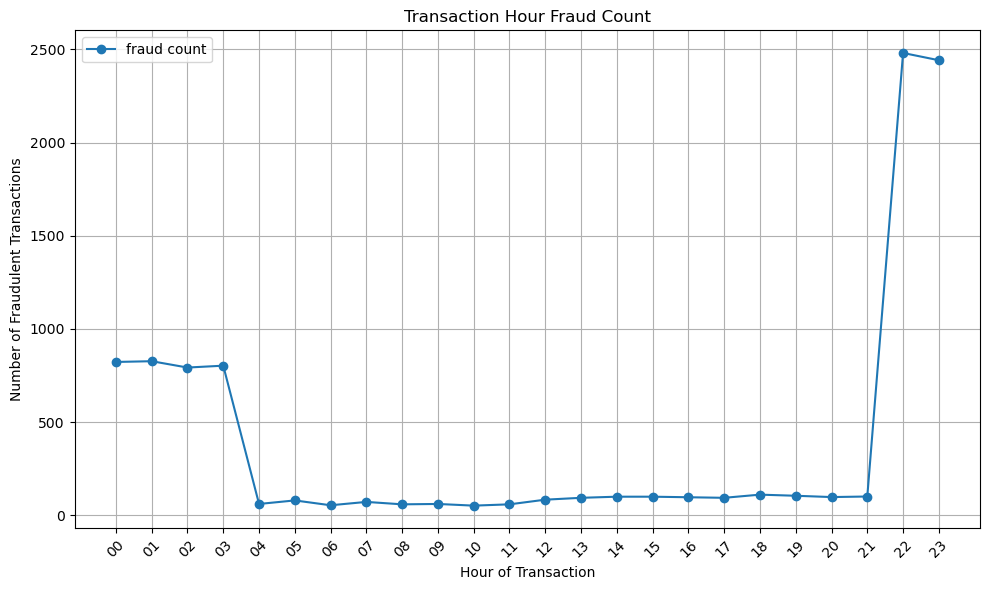

In [65]:
# hour summary
df_cat = (
    df.groupby('trans_hour', observed=True)
      .agg(
          total_transactions=('is_fraud', 'count'),
          total_fraud=('is_fraud', 'sum')
      )
      .sort_values(by='trans_hour')
      .reset_index()
)

# plotting the monthly fraud count
plt.figure(figsize=(10, 6))
plt.plot(df_cat['trans_hour'], df_cat['total_fraud'], marker='o', label='fraud count')
plt.title('Transaction Hour Fraud Count')
plt.xlabel('Hour of Transaction')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

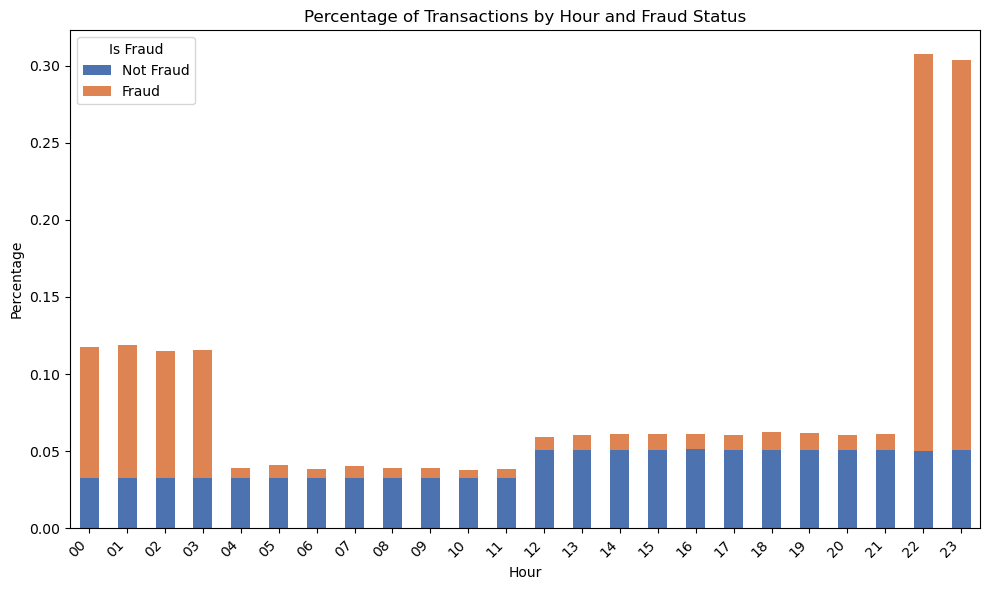


--- Contingency Table: Category vs. Is Fraud ---
is_fraud       0     1
trans_hour            
00          0.03  0.09
01          0.03  0.09
02          0.03  0.08
03          0.03  0.08
04          0.03  0.01
05          0.03  0.01
06          0.03  0.01
07          0.03  0.01
08          0.03  0.01
09          0.03  0.01
10          0.03  0.01
11          0.03  0.01
12          0.05  0.01
13          0.05  0.01
14          0.05  0.01
15          0.05  0.01
16          0.05  0.01
17          0.05  0.01
18          0.05  0.01
19          0.05  0.01
20          0.05  0.01
21          0.05  0.01
22          0.05  0.26
23          0.05  0.25


In [ ]:
# Creating the Contingency Table
contingency_table_percent_col = pd.crosstab(df['trans_hour'], df['is_fraud'], normalize='columns')
contingency_table_percent_col.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Hour')
plt.title('Percentage of Transactions by Hour and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Creating the Contingency Table ---
print("\n--- Contingency Table: Category vs. Is Fraud ---")
print(contingency_table_percent_col.round(2))

#### Summary
- Late-night hours (10 PM–11 PM) show the highest fraud percentages, far exceeding any other hour.
- Daytime hours (4 AM–9 PM) show very low fraud levels (~0.01%) despite higher non-fraud activity.
- Midnight to 3 AM has elevated fraud relative to non-fraud.
- Non-fraud remains fairly evenly distributed throughout the day.

#### Fraudsters are most active during late-night hours, likely exploiting reduced user vigilance and possible system oversight. Legitimate transactions peak during daytime, but that’s when fraud is least likely.

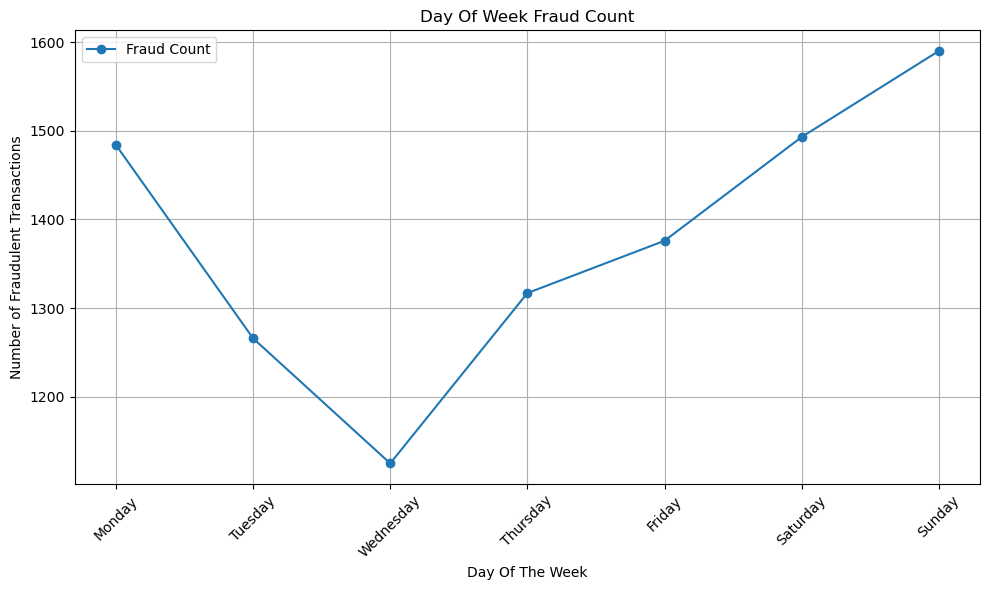

In [66]:
#  day of the week summary
df_cat = (
    df.groupby('trans_day_of_week', observed=True)
      .agg(
          total_transactions=('is_fraud', 'count'),
          total_fraud=('is_fraud', 'sum')
      )
      .sort_values(by='trans_day_of_week')
      .reset_index()
)

# plotting the monthly fraud count
plt.figure(figsize=(10, 6))
plt.plot(df_cat['trans_day_of_week'], df_cat['total_fraud'], marker='o', label='Fraud Count')
plt.title('Day Of Week Fraud Count')
plt.xlabel('Day Of The Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

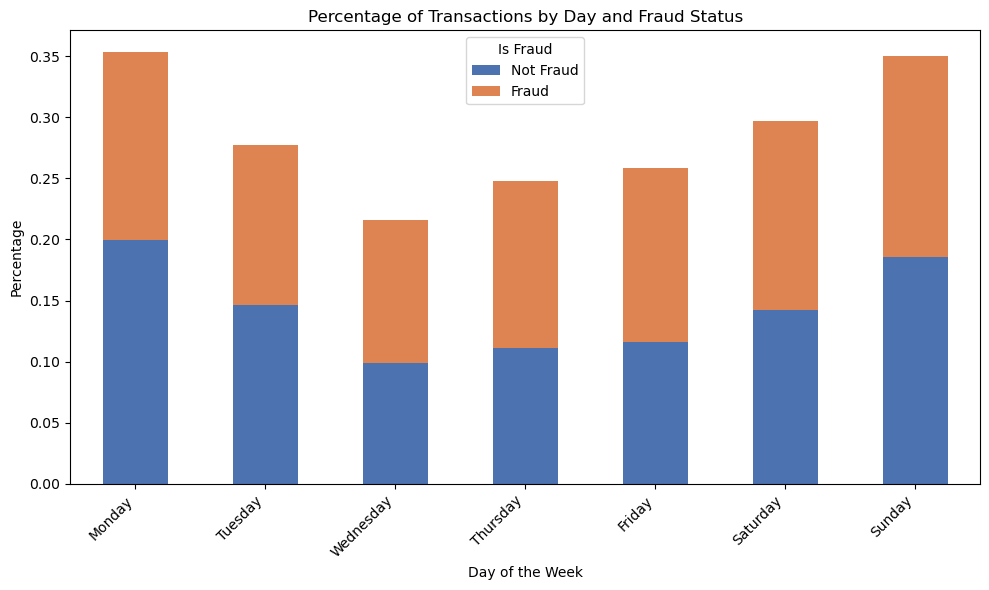


--- Contingency Table: Category vs. Is Fraud ---
is_fraud              0     1
trans_day_of_week            
Monday             0.20  0.15
Tuesday            0.15  0.13
Wednesday          0.10  0.12
Thursday           0.11  0.14
Friday             0.12  0.14
Saturday           0.14  0.15
Sunday             0.19  0.16


In [67]:
# --- Creating the Contingency Table ---
contingency_table_percent_col = pd.crosstab(df['trans_day_of_week'], df['is_fraud'], normalize='columns')
contingency_table_percent_col.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Day of the Week')
plt.title('Percentage of Transactions by Day and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Creating the Contingency Table ---
print("\n--- Contingency Table: Category vs. Is Fraud ---")
print(contingency_table_percent_col.round(2))

#### Summary
- Thursday and Friday have a higher share of fraud than their share of total transactions, suggesting elevated risk.
- Monday and Sunday see less fraud than expected, given their volume of total transactions.
- Saturday fraud is proportionate to transaction volume.

#### Fraudulent activity is more concentrated toward the end of the week, especially Thursday and Friday. This could reflect behavioral patterns of fraudsters — possibly exploiting end-of-week rush or reduced oversight.

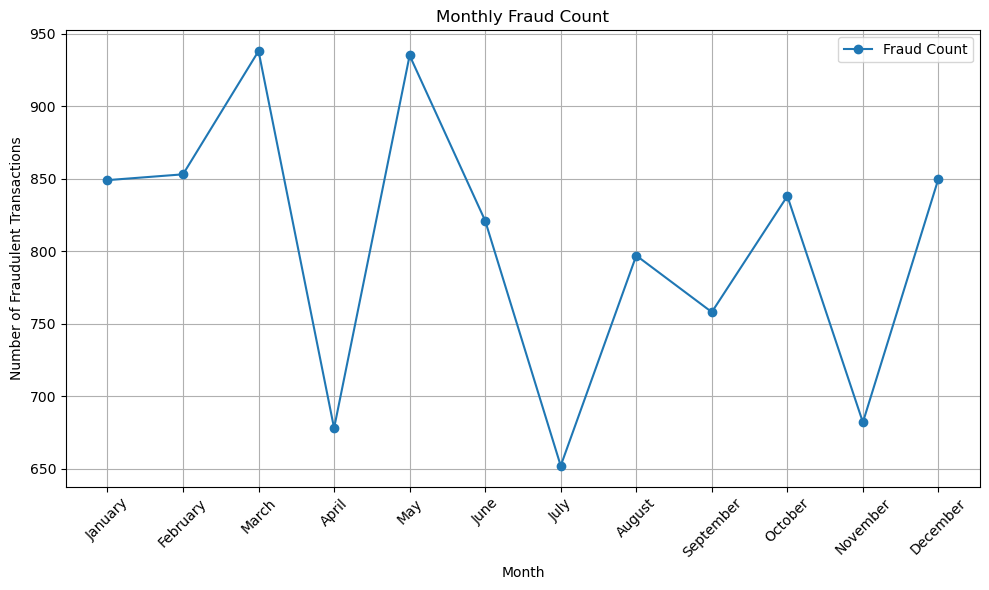

In [68]:
# monthly summary
df_cat = (
    df.groupby('trans_month', observed=True)
      .agg(
          total_transactions=('is_fraud', 'count'),
          total_fraud=('is_fraud', 'sum')
      )
      .sort_values(by='trans_month')
      .reset_index()
)

# plotting the monthly fraud count
plt.figure(figsize=(10, 6))
plt.plot(df_cat['trans_month'], df_cat['total_fraud'], marker='o', label='Fraud Count')
plt.title('Monthly Fraud Count')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

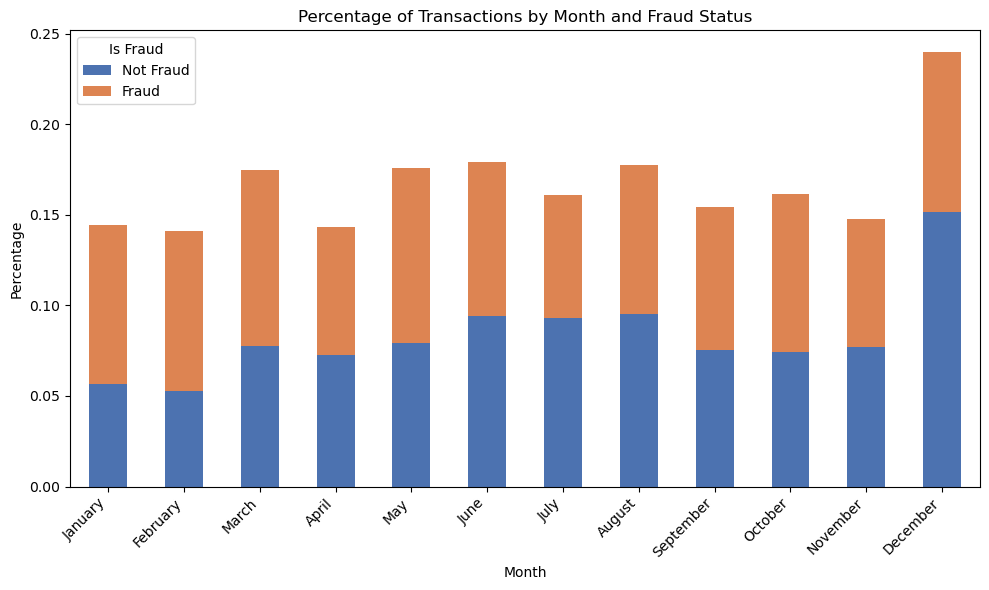


--- Contingency Table: Category vs. Is Fraud ---
is_fraud        0     1
trans_month            
January      0.06  0.09
February     0.05  0.09
March        0.08  0.10
April        0.07  0.07
May          0.08  0.10
June         0.09  0.09
July         0.09  0.07
August       0.10  0.08
September    0.08  0.08
October      0.07  0.09
November     0.08  0.07
December     0.15  0.09


In [69]:
# Creating the Contingency Table
contingency_table_percent_col = pd.crosstab(df['trans_month'], df['is_fraud'], normalize='columns')
contingency_table_percent_col.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Month')
plt.title('Percentage of Transactions by Month and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Creating the Contingency Table ---
print("\n--- Contingency Table: Category vs. Is Fraud ---")
print(contingency_table_percent_col.round(2))

#### Summary
- High Fraud Months:
    - February, January, March, and May show higher fraud rates relative to their transaction volume.
- Balanced Months:
    - April, June, and September show a fraud distribution that matches overall transaction activity.

- Low Fraud Months:
    - July, August, and December have lower fraud rates, especially December, which has the highest transaction volume (15%) but only 9% of fraud.

#### Fraud is disproportionately higher in the early part of the year (Jan–Mar) and lower during the holiday-heavy month of December, suggesting potential seasonal fraud patterns.

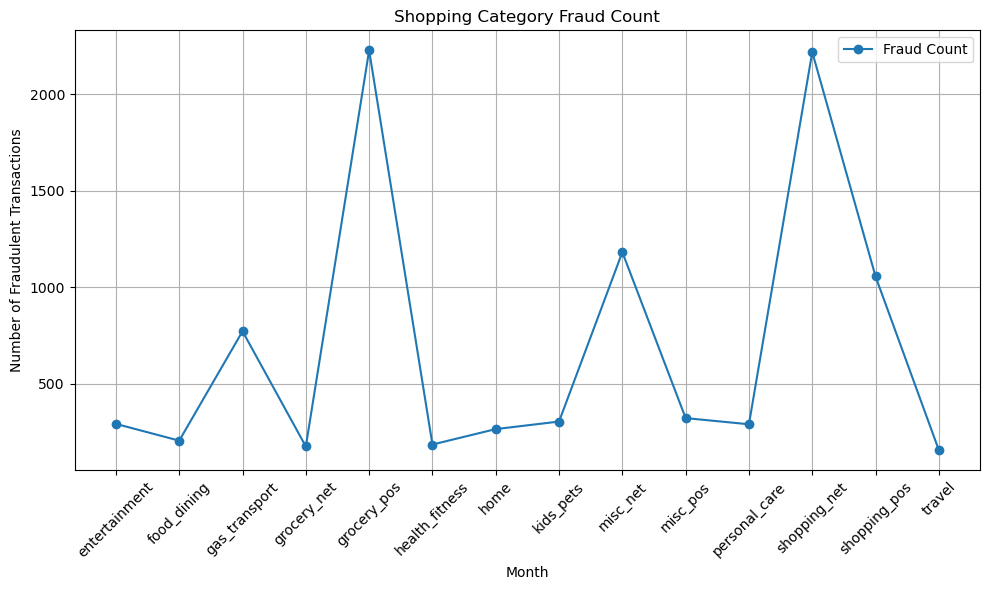

In [71]:
# monthly summary
df_cat = (
    df.groupby('category', observed=True)
      .agg(
          total_transactions=('is_fraud', 'count'),
          total_fraud=('is_fraud', 'sum')
      )
      .sort_values(by='category')
      .reset_index()
)

# plotting the monthly fraud count
plt.figure(figsize=(10, 6))
plt.plot(df_cat['category'], df_cat['total_fraud'], marker='o', label='Fraud Count')
plt.title('Shopping Category Fraud Count')
plt.xlabel('Month')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

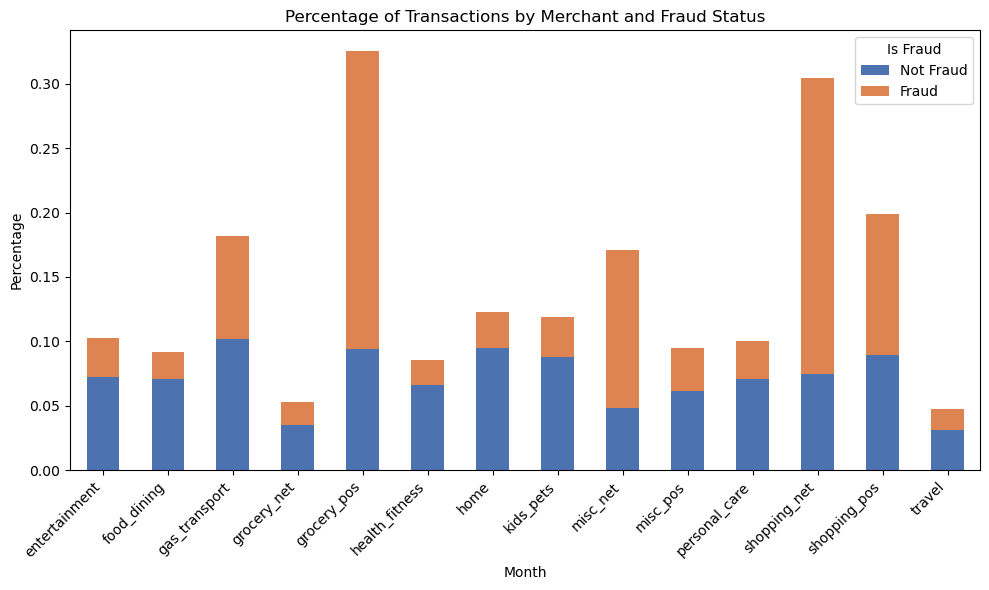


--- Contingency Table: Category vs. Is Fraud ---
is_fraud           0     1
category                  
entertainment   0.07  0.03
food_dining     0.07  0.02
gas_transport   0.10  0.08
grocery_net     0.04  0.02
grocery_pos     0.09  0.23
health_fitness  0.07  0.02
home            0.10  0.03
kids_pets       0.09  0.03
misc_net        0.05  0.12
misc_pos        0.06  0.03
personal_care   0.07  0.03
shopping_net    0.07  0.23
shopping_pos    0.09  0.11
travel          0.03  0.02


In [73]:
# Creating the Contingency Table
contingency_table_percent_col = pd.crosstab(df['category'], df['is_fraud'], normalize='columns')
contingency_table_percent_col.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['#4c72b0', '#dd8452']  # Optional: custom colors for clarity
)

plt.ylabel('Percentage')
plt.xlabel('Month')
plt.title('Percentage of Transactions by Merchant and Fraud Status')
plt.legend(['Not Fraud', 'Fraud'], title='Is Fraud')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Creating the Contingency Table ---
print("\n--- Contingency Table: Category vs. Is Fraud ---")
print(contingency_table_percent_col.round(2))

#### Summary
- High-Risk Categories:
    - grocery_pos and shopping_net are top fraud targets, each accounting for 23% of fraud but much lower share of total transactions.
    - misc_net also stands out with 12% of fraud from just 5% of transactions.

- Low-Risk Categories:
    - Categories like entertainment, food_dining, health_fitness, and travel show significantly less fraud than expected.

#### Monitor or flag transactions in grocery_pos, shopping_net, and misc_net with higher scrutiny and consider building category-based risk features for the fraud model.